# Analyze predicted escape from the 3K antibodies

## Import `Python` modules

In [1]:
import os
import glob
from collections import defaultdict
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Read in data that predicts how much each virus has escaped each antibody

Read in data

In [2]:
f = '/fh/fast/matsen_e/shared/dmsa-pred/ncov-dmsa/results/cao_predictions/imprinted_2022_abs/all_predictions.csv'
escape_df = pd.read_csv(f)
escape_df.rename(columns={'group':'ab_group'}, inplace=True)
escape_df.head()

,strain,aa_substitutions,escape_score,antibody,ab_group,date,Nextstrain_clade,time
0,ON641975.1,NaN,0.000000,BD55-6049,E3,2022-01-08,?,2.038356
1,ON641975.1,G446S N501Y,0.020197,BD56-965,B,2022-01-08,?,2.038356
2,ON641975.1,NaN,0.000000,XGv-318,F1,2022-01-08,?,2.038356
3,ON641975.1,NaN,0.000000,BD55-5687,E3,2022-01-08,?,2.038356
4,ON641975.1,E484A,0.005702,XGv-214,E2.1,2022-01-08,?,2.038356


We can use expressions like this to get a list of True/False values.

In [3]:
escape_df['time'] > 2.5

0          False
1          False
2          False
3          False
4          False
           ...  
8283991     True
8283992     True
8283993     True
8283994     True
8283995     True
Name: time, Length: 8283996, dtype: bool

First, we're interested in quantifying escape of viruses from antibodies in the last 6 months of the pandemic. To do this, we'll first get data for viruses from the past 6 months.

In [4]:
# Get data for all viruses after timepoint 2.5
recent_data = escape_df[escape_df['time'] > 2.5].copy()

Next, we will group the data by the antibody group. For each group, we will compute the average escape of all viruses from antibodies in that group.

In [5]:
avg_escape_data = recent_data.groupby('ab_group')['escape_score'].mean(numeric_only=True)
avg_escape_data

ab_group
A       0.881115
B       0.987711
C       1.178977
D1      1.016631
D2      0.676643
E1      0.903543
E2.1    0.528774
E2.2    0.223863
E3      0.071949
F1      0.086086
F2      0.544468
F3      0.855212
Name: escape_score, dtype: float64

**Observations**
* Many of the antibody groups have high average escape scores, some have mediocre escape scores
* What could explain this pattern? One idea is that the epitopes with low escape scores are non-neutralizing.

Next, we'll plot the above results as a histogram

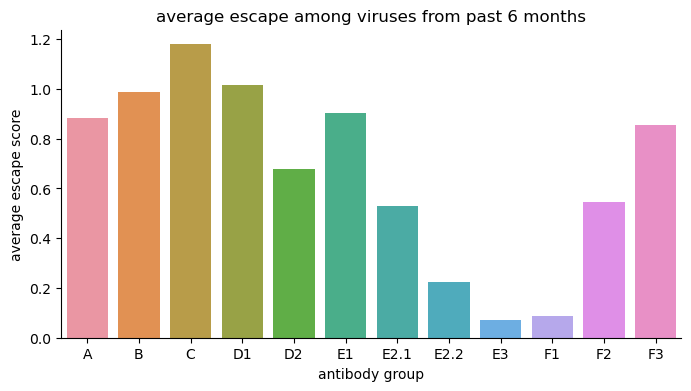

In [15]:
avg_escape_data = recent_data.groupby('ab_group').mean(numeric_only=True)
avg_escape_data.reset_index(inplace=True)
plt.figure(figsize=[8,4])
sns.barplot(x='ab_group', y='escape_score', data=avg_escape_data)
plt.title('average escape among viruses from past 6 months')
plt.xlabel('antibody group')
plt.ylabel('average escape score')
sns.despine()
plt.show()

Next, for each antibody group, we'll plot escape over time. To do this, we'll need to implement our sliding-window approach from before. First, we will define where our windows are.

In [22]:
# Define parameters for windows
start_time = 0
end_time = 3.3
window_width = 0.2
window_step_size = 0.1

# To start, we set the left side of our window at a value
# of zero
left_side_of_window = 0

# We're going to define all windows one at a time
# based on the step size and width
list_of_left_sides_of_windows = []
while left_side_of_window <= end_time:
    
    # Append the window value to the list
    list_of_left_sides_of_windows.append(left_side_of_window)
    #print(left_side_of_window, left_side_of_window+window_width)

    # Slide the window to the right by one step
    left_side_of_window = left_side_of_window + window_step_size

Next, for each window, we will record data in that window.

In [28]:
# Make a dictionary for keeping track of averages in each window
window_data = defaultdict(list)

# Get a sorted list of unique antibody groups
antibody_groups = sorted(escape_df['ab_group'].unique())

# Iterate over each window and record data
for left_side_of_window in list_of_left_sides_of_windows:
    right_side_of_window = left_side_of_window + window_width
    
    # Loop over antibodies, and compute the average amount that
    # viruses have escaped each antibody
    for antibody_group in antibody_groups:
        
        # Get data for viruses within a given window
        data = escape_df[
            (escape_df['time'].between(left_side_of_window, right_side_of_window)) &
            (escape_df['ab_group'] == antibody_group)
        ]
        
        window_data["left_side"].append(left_side_of_window)
        window_data["antibody_group"].append(antibody_group)
        window_data["mean_escape"].append(data['escape_score'].mean())
            
window_data = pd.DataFrame(window_data)
print(window_data.info())
window_data.head()

In [30]:
window_data = pd.DataFrame(window_data)
print(window_data.info())
window_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   left_side       396 non-null    float64
 1   antibody_group  396 non-null    object 
 2   mean_escape     396 non-null    float64
dtypes: float64(2), object(1)
memory usage: 9.4+ KB
None


,left_side,antibody_group,mean_escape
0,0.0,A,0.001927
1,0.0,B,0.000152
2,0.0,C,0.000205
3,0.0,D1,0.000451
4,0.0,D2,0.002466


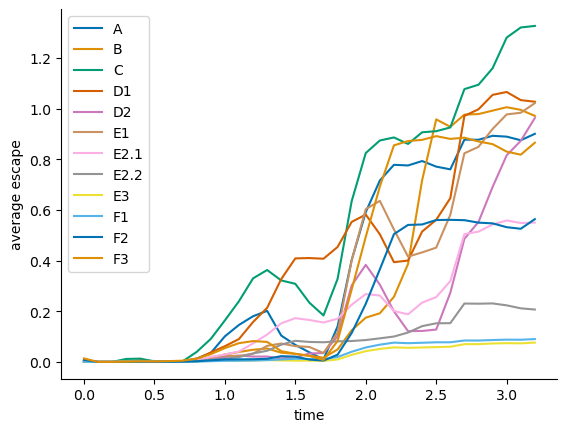

In [42]:
sns.lineplot(
    x='left_side', y='mean_escape', data=window_data,
    hue='antibody_group', palette='colorblind'
)
plt.legend()
plt.xlabel('time')
plt.ylabel('average escape')
sns.despine()
plt.show()

Let's make these plots in the future
* plot showing average escape of viruses for each antibody in each group, and having different graphs for different antibody groups

* for each antibody group, analyze patterns by clade

In [36]:
len(data['antibody'].unique())

2778

Here's a way to "pivot" the dataframe so that it's the same format we had before with the 5-10 antibodies.

In [16]:
data = escape_df.pivot_table(
    index=['strain', 'date'],
    columns=['antibody'],
    values=['escape_score']
)
data.head()

escape_score                            \
antibody                                     1-57 2-15  7D6   ADG-2     B38   
strain                    date                                                
ARG/210316-1/2021         2021-03-15      0.01807  1.0  1.0  0.1329  0.6096   
ARG/Cordoba-13221/2020    2020-09-19      0.00000  0.0  0.0  0.0000  0.0000   
ARG/Cordoba-189-251/2020  2020-05-16      0.00000  0.0  0.0  0.0000  0.0000   
ARG/Cordoba-2635-202/2020 2020-06-04      0.00000  0.0  0.0  0.0000  0.0000   
ARM/UW-ARM49/2020         2020-09-09      0.00000  0.0  0.0  0.0000  0.0000   

                                                                           \
antibody                              BD-196 BD-218  BD-236 BD-254 BD-255   
strain                    date                                              
ARG/210316-1/2021         2021-03-15  0.8258    0.0  0.3139    1.0    0.0   
ARG/Cordoba-13221/2020    2020-09-19  0.0000    0.0  0.0000    0.0    0.0   
ARG/Cordoba-189-251/2020  2020-05-16  0.0000    0.0  0.0000    0.0    0.0   
ARG/Cordoba-2635-202/2020 2020-06-04  0.0000    0.0  0.0000    0.0    0.0   
ARM/UW-ARM49/2020         2020-09-09  0.0000    0.0  0.0000    0.0    0.0   

                                      ...                                   \
antibody                              ... XGv-402 XGv-404 XGv-405  XGv-409   
strain                    date        ...                                    
ARG/210316-1/2021         2021-03-15  ...     0.0  0.5236  0.1012  0.04482   
ARG/Cordoba-13221/2020    2020-09-19  ...     0.0  0.0000  0.0000  0.00000   
ARG/Cordoba-189-251/2020  2020-05-16  ...     0.0  0.0000  0.0000  0.00000   
ARG/Cordoba-2635-202/2020 2020-06-04  ...     0.0  0.0000  0.0000  0.00000   
ARM/UW-ARM49/2020         2020-09-09  ...     0.0  0.0000  0.0000  0.00000   

                                                                               \
antibody                             XGv-412  XGv-416 XGv-418 XGv-420 XGv-421   
strain                    date                                                  
ARG/210316-1/2021         2021-03-15     0.0  0.04297     0.0     0.0     0.0   
ARG/Cordoba-13221/2020    2020-09-19     0.0  0.00000     0.0     0.0     0.0   
ARG/Cordoba-189-251/2020  2020-05-16     0.0  0.00000     0.0     0.0     0.0   
ARG/Cordoba-2635-202/2020 2020-06-04     0.0  0.00000     0.0     0.0     0.0   
ARM/UW-ARM49/2020         2020-09-09     0.0  0.00000     0.0     0.0     0.0   

                                              
antibody                             XGv-422  
strain                    date                
ARG/210316-1/2021         2021-03-15  0.0493  
ARG/Cordoba-13221/2020    2020-09-19  0.0000  
ARG/Cordoba-189-251/2020  2020-05-16  0.0000  
ARG/Cordoba-2635-202/2020 2020-06-04  0.0000  
ARM/UW-ARM49/2020         2020-09-09  0.0000  

[5 rows x 2778 columns]

In this dataframe, each row is a virus, and each column gives some information for that virus
* `strain`: the name of the virus
* `aa_substitutions`: gives the mutation(s) in the virus
* `escape_score`: the amount that a virus has escaped a given antibody. this score starts at zero (no escape) and can go up to 1.0, or even larger sometimes.
* `antibody`: this gives the name of the antibody associated with a given escape score.
* `ab_group`: the group a given antibody is in. Antibodies in the same group target a similar region of the spike protein.
* `date`: the date that a virus was isolated.
* `time`: the same as date, but it is the number of years that have elapsed since the beginning of the pandemic.

## Get a feel for the data

How long is the dataframe?

In [8]:
len(escape_df)

8283996

How many antibodies are in the dataset?

In [9]:
len(escape_df['antibody'].unique())

2778

How many viruses are in the dataset?

In [10]:
len(escape_df['strain'].unique())

2982

In [11]:
2778*2982

8283996

How many different antibody groups are there?

In [13]:
sorted(escape_df['ab_group'].unique())

['A', 'B', 'C', 'D1', 'D2', 'E1', 'E2.1', 'E2.2', 'E3', 'F1', 'F2', 'F3']

## Analyze escape

* How many antibodies have been escaped? To answer this, we can plot the average escape score of all viruses from the past 6 months
* How has average escape changed over time? To answer this, we can plot average escape over time. This is a lot of curves to plot. We've come up with a few ideas for making things simpler
    * making ~30 plots each with 100 curves
    * plotting data separately for different groups
    * averaging escape across all antibodies in a given group
* Can we group antibodies by their escape patterns?